### This notebook is a submission for the hackathon 

https://www.kaggle.com/c/santander-customer-transaction-prediction

In [1]:
import sys
!{sys.executable} -m pip install --user modAL

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
#import xgboost as xgb
#import lightgbm as lgbm
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import KFold
import time

In [5]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')

In [6]:
def train_model(model,train,target,test,samples=-1,**params):    
    kford=KFold(n_splits=5,random_state=2,shuffle=True,)
    start_time=time.time()
    aucs=[]

    test_preds=[]
    # for early stopping
    # it takes a long time if using all the samples.
    if samples<=-1:
        samples=train.shape[0]
    else:
        samples=min(train.shape[0],samples)
    print("Started to fit model")
    print("fit on {} samples".format(samples))
    for ford,(train_idx,val_idx) in enumerate(kford.split(train[:samples],target[:samples])):
        print("ford:",ford)
        sample_x=train.iloc[train_idx].values
        sample_y=target.iloc[train_idx].values

        sample_val_x=train.iloc[val_idx].values
        sample_val_y=target.iloc[val_idx].values
        
        ford_time=time.time()
        model.fit(sample_x,sample_y)
        print("epoch cost time {:1}s".format(time.time()-ford_time))
        y_pred_prob=model.predict_proba(sample_x)[:,1]
        y_val_pred_prob=model.predict_proba(sample_val_x)[:,1]

        train_auc=metrics.roc_auc_score(sample_y,y_pred_prob)
        val_auc=metrics.roc_auc_score(sample_val_y,y_val_pred_prob)
        print("train auc:{:4},val auc:{:4}".format(train_auc,val_auc))
        aucs.append([train_auc,val_auc])
        test_preds.append(model.predict_proba(test)[:,1])

    end_time=time.time()
    val_aucs=[auc[1] for auc in aucs]
    print("using {} samples,total time:{:1}s,mean val auc:{:4}".format(samples,end_time-start_time,np.mean(val_aucs)))
    test_preds=pd.DataFrame(test_preds).T
    test_preds.index=test.index
    return test_preds

In [7]:
train.shape

(200000, 202)

In [8]:
target = train['target']

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [10]:
train_df = train[0:]

In [11]:
train_df.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [12]:
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour(n_jobs=-1)

In [13]:
del train['ID_code']
del train['target']

In [14]:
train.tail(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
199995,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,5.6669,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,6.0019,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,6.1629,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,8.7542,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001
199999,10.8762,-5.7105,12.1183,8.0328,11.5577,0.3488,5.2839,15.2058,-0.4541,9.3688,...,8.9842,1.6893,0.1276,0.3766,15.2101,-2.4907,-2.2342,8.1857,12.1284,0.1385


In [15]:
from imblearn.under_sampling import CondensedNearestNeighbour,RandomUnderSampler,NearMiss # doctest: +SKIP

In [16]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

In [17]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=train[:10000], y_training=target[:10000]
)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from modAL.models import ActiveLearner


In [79]:
train.values[0:10000].shape

(10000, 200)

In [86]:
# initial training data
X_train = train.values[0:10000]
y_train = target.values[0:10000]

In [97]:
# generating the pool
X_pool = np.delete(train.values, (10000, 200), axis=0)
y_pool = np.delete(target.values,(10000, 200))

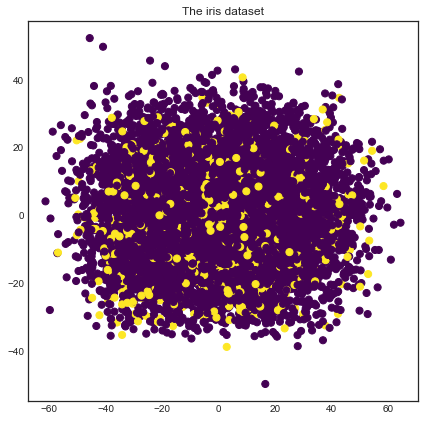

In [102]:
# visualizing the classes
with plt.style.context('seaborn-white'):
    pca = PCA(n_components=2).fit_transform(X_train)
    plt.figure(figsize=(7, 7))
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=y_train, cmap='viridis', s=50)
    plt.title('The iris dataset')
    plt.show()


In [103]:
y_pool.shape

(199998,)

In [104]:
# initializing the active learner
learner = ActiveLearner(
    estimator=KNeighborsClassifier(n_neighbors=2),
    X_training=X_train, y_training=y_train
)

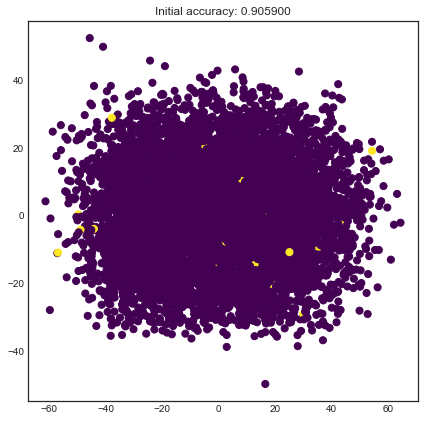

Accuracy before active learning: 0.905900


In [105]:
# visualizing initial prediction
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    prediction = learner.predict(X_train)
    plt.scatter(x=pca[:, 0], y=pca[:, 1], c=prediction, cmap='viridis', s=10000)
    plt.title('Initial accuracy: %f' % learner.score(X_train,y_train))
    plt.show()

print('Accuracy before active learning: %f' % learner.score(X_train,y_train))

In [57]:
rus = RandomUnderSampler(random_state=42) # doctest: +SKIP
X_res, y_res = rus.fit_resample(train, target) #doctest: +SKIP


In [ ]:
nm = NearMiss(random_state=42) # doctest: +SKIP
X_res_nm, y_res_nm = nm.fit_resample(train, target) #doctest: +SKIP

In [62]:
X_res = pd.DataFrame(X_res,columns=train.columns)
y_res = pd.DataFrame(y_res,columns={'target'})

In [40]:
X_res.shape

(40196, 200)

In [50]:
test.head(2)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760


In [52]:
del test['ID_code']

In [51]:
pd.Series(y_res).value_counts()

1    20098
0    20098
dtype: int64

In [43]:
pd.Series(target).value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [54]:
model=RandomForestClassifier()
test_preds=train_model(model,train,target,test,samples=-1)

Started to fit model
fit on 200000 samples
ford: 0


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


epoch cost time 69.39088296890259s
train auc:0.9998305688082499,val auc:0.6945851668270764
ford: 1
epoch cost time 69.01595401763916s
train auc:0.9998732353572511,val auc:0.6974255043238419
ford: 2
epoch cost time 70.80818915367126s
train auc:0.9998771645894939,val auc:0.6946866440609263
ford: 3
epoch cost time 67.9989058971405s
train auc:0.9998260083888362,val auc:0.7027257931572557
ford: 4
epoch cost time 69.68490982055664s
train auc:0.9998333127590734,val auc:0.6994548839929424
using 200000 samples,total time:360.6515111923218s,mean val auc:0.6977755984724086


In [64]:
test_preds_rusample=train_model(model,X_res,y_res,test,samples=-1)

Started to fit model
fit on 40196 samples
ford: 0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


epoch cost time 5.737301826477051s
train auc:0.9996139188516053,val auc:0.6884135512412352
ford: 1


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


epoch cost time 5.515974760055542s
train auc:0.9995461459862682,val auc:0.6889783025491868
ford: 2


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


epoch cost time 5.580164194107056s
train auc:0.9996032980824335,val auc:0.6888048647022483
ford: 3


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


epoch cost time 5.5560760498046875s
train auc:0.9995631392684671,val auc:0.6966427547267822
ford: 4


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


epoch cost time 5.7690041065216064s
train auc:0.99951908562234,val auc:0.6968570521354999
using 40196 samples,total time:33.005250692367554s,mean val auc:0.6919393050709906


In [65]:
from imblearn.under_sampling import NearMiss

In [ ]:


def run(trn_ds, tst_ds, lbr, model, qs, quota):
    E_in, E_out = [], []

    for _ in range(quota):
        # Standard usage of libact objects
        ask_id = qs.make_query()
        X, _ = zip(*trn_ds.data)
        lb = lbr.label(X[ask_id])
        trn_ds.update(ask_id, lb)

        model.train(trn_ds)
        E_in = np.append(E_in, 1 - model.score(trn_ds))
        E_out = np.append(E_out, 1 - model.score(tst_ds))

    return E_in, E_out


def split_train_test(dataset_filepath, test_size, n_labeled):
    X, y = import_libsvm_sparse(dataset_filepath).format_sklearn()

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size)
    trn_ds = Dataset(X_train, np.concatenate(
        [y_train[:n_labeled], [None] * (len(y_train) - n_labeled)]))
    tst_ds = Dataset(X_test, y_test)
    fully_labeled_trn_ds = Dataset(X_train, y_train)

    return trn_ds, tst_ds, y_train, fully_labeled_trn_ds


def main():
    # Specifiy the parameters here:
    # path to your binary classification dataset
    dataset_filepath = os.path.join(
        os.path.dirname(os.path.realpath(__file__)), 'diabetes.txt')
    test_size = 0.33    # the percentage of samples in the dataset that will be
    # randomly selected and assigned to the test set
    n_labeled = 10      # number of samples that are initially labeled

    # Load dataset
    trn_ds, tst_ds, y_train, fully_labeled_trn_ds = \
        split_train_test(dataset_filepath, test_size, n_labeled)
    trn_ds2 = copy.deepcopy(trn_ds)
    lbr = IdealLabeler(fully_labeled_trn_ds)

    quota = len(y_train) - n_labeled    # number of samples to query

    # Comparing UncertaintySampling strategy with RandomSampling.
    # model is the base learner, e.g. LogisticRegression, SVM ... etc.
    qs = UncertaintySampling(trn_ds, method='lc', model=LogisticRegression())
    model = LogisticRegression()
    E_in_1, E_out_1 = run(trn_ds, tst_ds, lbr, model, qs, quota)

    qs2 = RandomSampling(trn_ds2)
    model = LogisticRegression()
    E_in_2, E_out_2 = run(trn_ds2, tst_ds, lbr, model, qs2, quota)

    # Plot the learning curve of UncertaintySampling to RandomSampling
    # The x-axis is the number of queries, and the y-axis is the corresponding
    # error rate.
    query_num = np.arange(1, quota + 1)
    plt.plot(query_num, E_in_1, 'b', label='qs Ein')
    plt.plot(query_num, E_in_2, 'r', label='random Ein')
    plt.plot(query_num, E_out_1, 'g', label='qs Eout')
    plt.plot(query_num, E_out_2, 'k', label='random Eout')
    plt.xlabel('Number of Queries')
    plt.ylabel('Error')
    plt.title('Experiment Result')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
    plt.show()


if __name__ == '__main__':
    main()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [15]:
model=lgbm.LGBMClassifier(n_estimators= 500, learning_rate= 0.1,num_leaves=31)
test_preds=train_model(model,train,target,test,samples=-1)

Started to fit model
fit on 200000 samples
('ford:', 0)
epoch cost time 33.8785820007s
train auc:0.989769426325,val auc:0.889734858216


ValueError: Number of features of the model must match the input. Model n_features_ is 200 and input n_features is 201 

In [ ]:
submission=pd.DataFrame(test_preds.mean(axis=1),columns=["target"])

In [ ]:
#test_tar = pd.DataFrame(prediction,columns=['target'])
pd.concat([test_id,submission],axis=1).to_csv('GNB.csv',index=False)

In [ ]:
submission

In [ ]:
# Create a lgb dataset
train_set = lgb.Dataset(features, label = labels)

In [ ]:
stdc = StandardScaler()
train_normalized = stdc.fit_transform(train)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train,target,test_size=0.2)

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test,y_pred)

In [ ]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train,y_train)

In [ ]:
y_pred_xgb = xgbc.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred_xgb)

In [ ]:
prediction = xgbc.predict(test_normalized)

test_tar = pd.DataFrame(prediction,columns=['target'])
pd.concat([test_id,test_tar],axis=1).to_csv('xgb.csv',index=False)

In [ ]:
lgbmc = lgbm.LGBMClassifier()
lgbmc.fit(X_train,y_train)
y_pred_lgbm = lgbmc.predict(X_test)
accuracy_score(y_test,y_pred_lgbm)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
import keras
from keras import regularizers

In [ ]:
X=np.array(train).astype(float)  
Y=np.array(target).astype(np.int32)

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
sgd = keras.optimizers.SGD(lr=0.005, momentum=0.0, decay=0.0, nesterov=False)

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=200))
model.add(Dropout(0.5))
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])     
model.fit(X,Y,verbose=1,shuffle=True, nb_epoch=10,batch_size=100,validation_split=0.2)


In [ ]:
model.predict(np.array(test).astype(float) )

In [ ]:
test_tar = pd.DataFrame(model.predict_classes(np.array(test).astype(float)),columns=['target'])
pd.concat([test_id,test_tar],axis=1).to_csv('dnn.csv',index=False)

In [ ]:
pd.DataFrame(model.predict_classes(np.array(test).astype(float)),columns=['target']).target.value_counts()

In [ ]:
test

In [ ]:
train_df['target'].value_counts()

In [ ]:
test_id = test['ID_code']
del test['ID_code']

In [ ]:
test_normalized = stdc.fit_transform(test)


In [ ]:
prediction = lgbmc.predict_proba(test)

In [ ]:
predic = prediction[:,1]

In [ ]:
test_tar = pd.DataFrame(predic,columns=['target'])
pd.concat([test_id,test_tar],axis=1).to_csv('lgbm.csv',index=False)

In [ ]:
test_tar.target.value_counts()